<h1> Cleaning Data</h1>

In [1]:
import pandas as pd
import numpy as np

In [2]:
data = pd.read_csv(r'https://raw.githubusercontent.com/MinhTrong92/Final-Test/main/FINAL/prices.csv', index_col=0)

In [3]:
data

,Date,Price
0,28/02/2022,"1,490.13"
1,25/02/2022,"1,498.89"
2,24/02/2022,"1,494.85"
3,23/02/2022,"1,512.30"
4,22/02/2022,"1,503.47"
...,...,...
1281,09/01/2017,682.57
1282,06/01/2017,679.80
1283,05/01/2017,675.81
1284,04/01/2017,674.70


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1286 entries, 0 to 1285
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1286 non-null   object
 1   Price   1286 non-null   object
dtypes: object(2)
memory usage: 30.1+ KB


<h4>Chuyển đổi dạng dữ liệu</h4>

In [5]:
data['Price'] = pd.to_numeric(data['Price'].astype(str).str.replace(',', ''), errors='coerce')

In [6]:
data['Date'] = pd.to_datetime(data.Date,format='%d/%m/%Y')

In [7]:
data = data.sort_values(by="Date")

In [8]:
data = data.reset_index(drop=True)

In [9]:
data.set_index('Date',inplace=True)

In [10]:
data

,Price
Date,
2017-01-03,672.01
2017-01-04,674.70
2017-01-05,675.81
2017-01-06,679.80
2017-01-09,682.57
...,...
2022-02-22,1503.47
2022-02-23,1512.30
2022-02-24,1494.85


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1286 entries, 2017-01-03 to 2022-02-28
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Price   1286 non-null   float64
dtypes: float64(1)
memory usage: 20.1 KB


<h4>Visual data</h4>

In [12]:
import matplotlib.pyplot as plt

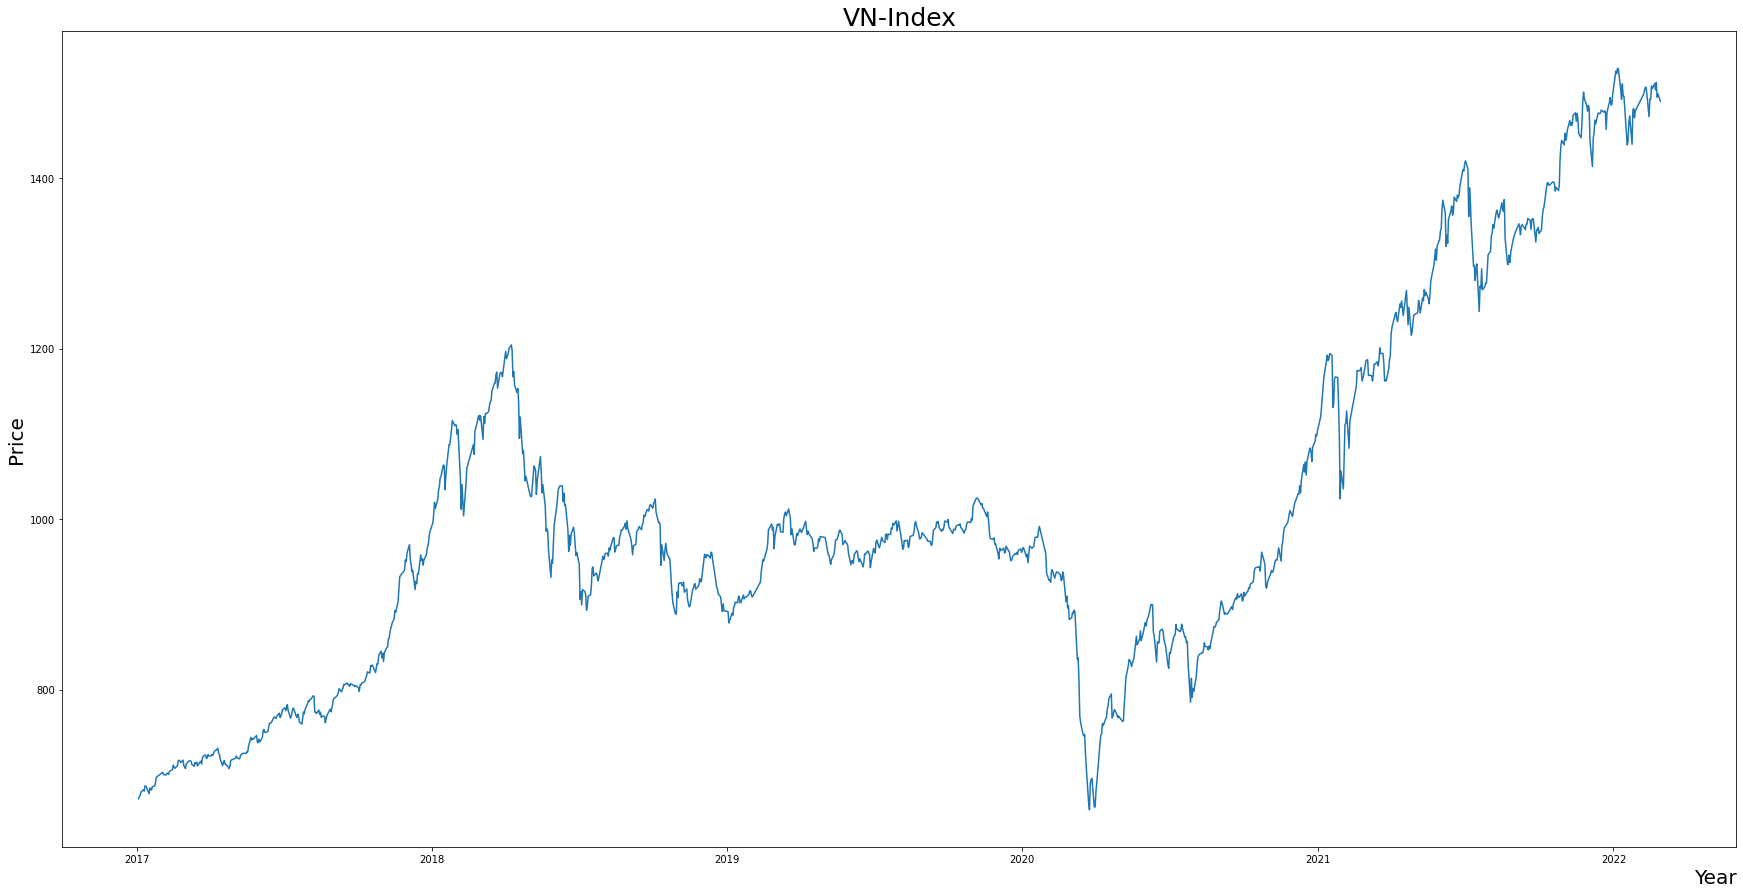

In [13]:
plt.figure(figsize=(30,15))
plt.plot(data)

plt.ylabel('Price', fontsize=20)
plt.xlabel('Year', fontsize=20, loc='right')

plt.title("VN-Index", fontsize=25)
plt.show()

<h1> Xây dựng mô hình </h1>

<h2> Kiểm định tính dừng của chuỗi dữ liệu </h2>

In [14]:
from statsmodels.tsa.stattools import adfuller

In [15]:
def adfuller_test(price):
    result = adfuller(price)
    labels = ['ADF Test Statistic','p-value']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )

    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary ")

In [16]:
adfuller_test(data['Price'])

ADF Test Statistic : -0.49266203245375895
p-value : 0.8934405146580287
Data is non-stationary 


**Nhận xét:** Chuỗi dự liệu là chuỗi không dừng, tiến hành đưa chuỗi dữ liệu về chuối dừng bằng cách lấy sai phân bậc 1.

In [17]:
data['Price First Difference'] = data['Price'] - data['Price'].shift(1)

<AxesSubplot:xlabel='Date'>

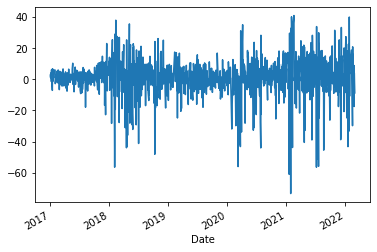

In [18]:
data['Price First Difference'].plot()

In [19]:
adfuller_test(data['Price First Difference'].dropna())

ADF Test Statistic : -23.189259298085133
p-value : 0.0
Data is stationary


<h4> Sau khi lấy sai phận bậc 1, chuỗi dữ liệu đã cho là chuỗi dừng. Như vậy hệ số d trong mô hình ARIMA được xác định là 1</h4>

<h2> Xác định hệ số p, q cho cho mô hình ARIMA </h2>

<h4>Sử dụng ACF để tìm hệ số q, độ trễ của quá trình trung bình trượt MA(q)</h4>

<Figure size 576x432 with 0 Axes>

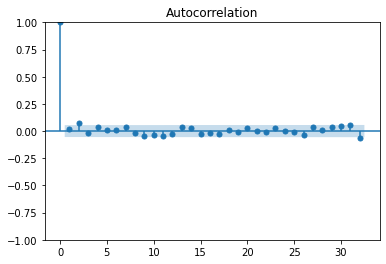

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))
ax1 = plot_acf(data['Price First Difference'].dropna())

**Nhận xét:** Hệ số q được chọn là 2 vì tại độ trễ 2, độ dài đại diện cho giá trị của hệ số tự tương quan nằm ngoài khoảng tin cậy.

<h4>Sử dụng PACF xác định hệ số p, hệ số bậc tự do p của quá trình tự hồi qui AR(p)</h4>

c:\users\minh trong\appdata\local\programs\python\python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 576x432 with 0 Axes>

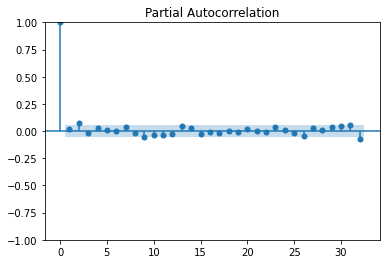

In [21]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 6))
ax2 = plot_pacf(data['Price First Difference'].dropna())

**Nhận xét** Hệ số p được chọn là 2 vì tại độ trễ 2, độ dài đại diện cho giá trị của hệ số tự tương quan nằm ngoài khoảng tin cậy.

Kết hợp giữa bậc của p và q và giá trị của d=1 ta có kịch bản ARIMA(2, 1, 2)

<h2> Phương pháp Auto ARIMA </h2>

In [22]:
train_data, test_data = data[0:int(len(data)*0.8)], data[int(len(data)*0.8):]

In [23]:
import pmdarima as pm
model = pm.auto_arima(train_data.Price, start_p=0, start_q=0, test='adf',
                           max_p=5, max_q=5, m=1,
                           start_P=0, seasonal=False,
                           d=None, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print(model.aic())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7854.592, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7855.229, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7855.503, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7854.153, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=7849.850, Time=0.26 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7842.846, Time=0.14 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7840.855, Time=0.12 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=7842.845, Time=0.17 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=7844.845, Time=0.21 sec
 ARIMA(2,1,0)(0,0,0)[0]             : AIC=7839.978, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=7854.686, Time=0.03 sec
 ARIMA(3,1,0)(0,0,0)[0]             : AIC=7841.960, Time=0.09 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=7841.962, Time=0.08 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=7848.902, Time=0.14 sec
 ARIMA(3,1,1)(0,0,0)[0]          

Kết quả mô hình tốt nhất thu được là ARIMA(2,1,0)

<h2> Dự báo </h2>

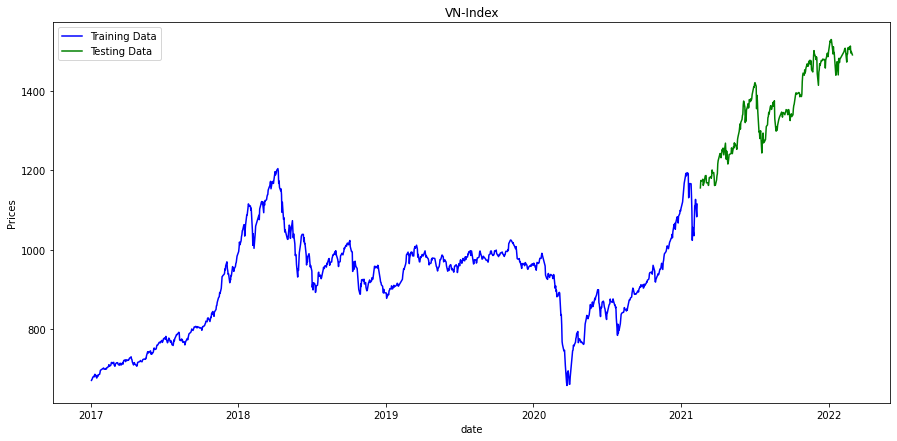

In [24]:
# Create Training and Test
train_data, test_data = data[0:int(len(data)*0.8)], data[int(len(data)*0.8):]
plt.figure(figsize=(15,7))
plt.title('VN-Index')
plt.xlabel('date')
plt.ylabel('Prices')
plt.plot(train_data['Price'], 'blue', label='Training Data')
plt.plot(test_data['Price'], 'green', label='Testing Data')
plt.legend()

In [25]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from math import sqrt

<h4> Dự báo với mô hình ARIMA(2,1,2) </h4>

In [26]:
train_ar = train_data['Price'].values
test_ar = test_data['Price'].values
from sklearn.metrics import mean_squared_error

history = [x for x in train_ar]
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(2,1,2)) 
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
#     print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test_ar, predictions))
mse = mean_squared_error(test_ar, predictions)

In [27]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1285
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -5002.209
Date:                Sun, 06 Mar 2022   AIC                          10014.417
Time:                        22:00:56   BIC                          10040.206
Sample:                             0   HQIC                         10024.099
                               - 1285                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0394      0.221     -0.179      0.858      -0.472       0.393
ar.L2          0.3491      0.215      1.626      0.104      -0.072       0.770
ma.L1          0.0563      0.225      0.251      0.8

In [28]:
print('Testing RMSE: %.3f' % rmse)
print('Testing MSE: %.3f' % mse)

Testing RMSE: 15.134
Testing MSE: 229.038


In [29]:
from sklearn.metrics import mean_absolute_error

In [30]:
mae = mean_absolute_error(test_ar, predictions)
mae

10.817975054919756

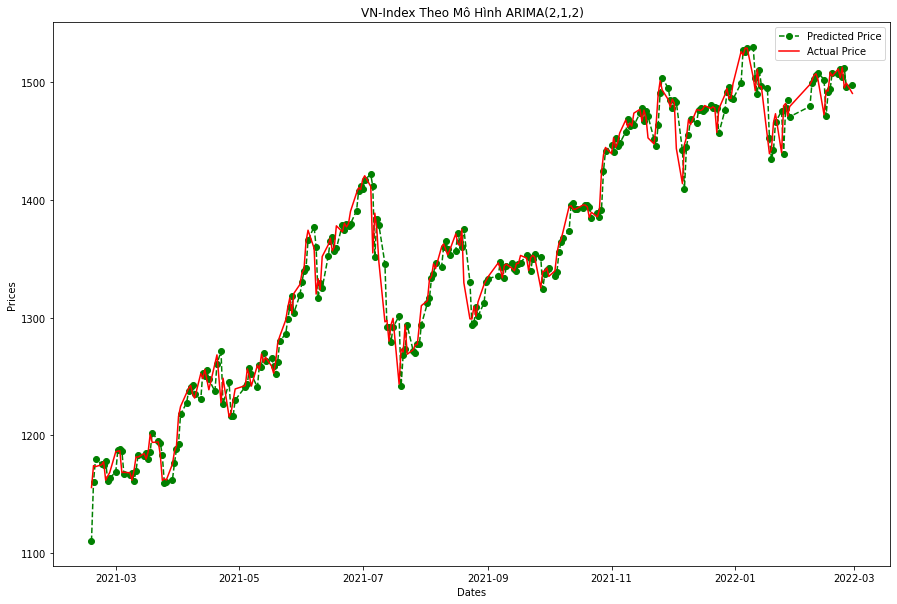

In [31]:
plt.figure(figsize=(15,10))

plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Price'], color='red', label='Actual Price')

plt.title('VN-Index Theo Mô Hình ARIMA(2,1,2)')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

<h4> Dự báo với mô hình ARIMA(2,1,0) </h4>

In [32]:
train_ar = train_data['Price'].values
test_ar = test_data['Price'].values
from sklearn.metrics import mean_squared_error

history = [x for x in train_ar]
predictions = list()
for t in range(len(test_ar)):
    model = ARIMA(history, order=(2,1,0)) 
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
#     print('predicted=%f, expected=%f' % (yhat, obs))
rmse = sqrt(mean_squared_error(test_ar, predictions))
mse = mean_squared_error(test_ar, predictions)

In [33]:
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1285
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -5002.728
Date:                Sun, 06 Mar 2022   AIC                          10011.456
Time:                        22:01:40   BIC                          10026.929
Sample:                             0   HQIC                         10017.265
                               - 1285                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0190      0.017      1.138      0.255      -0.014       0.052
ar.L2          0.0795      0.018      4.339      0.000       0.044       0.115
sigma2       141.8137      3.031     46.790      0.0

In [34]:
print('Testing RMSE: %.3f' % rmse)
print('Testing MSE: %.3f' % mse)

Testing RMSE: 15.105
Testing MSE: 228.150


In [35]:
mae = mean_absolute_error(test_ar, predictions)
mae

10.805835439273725

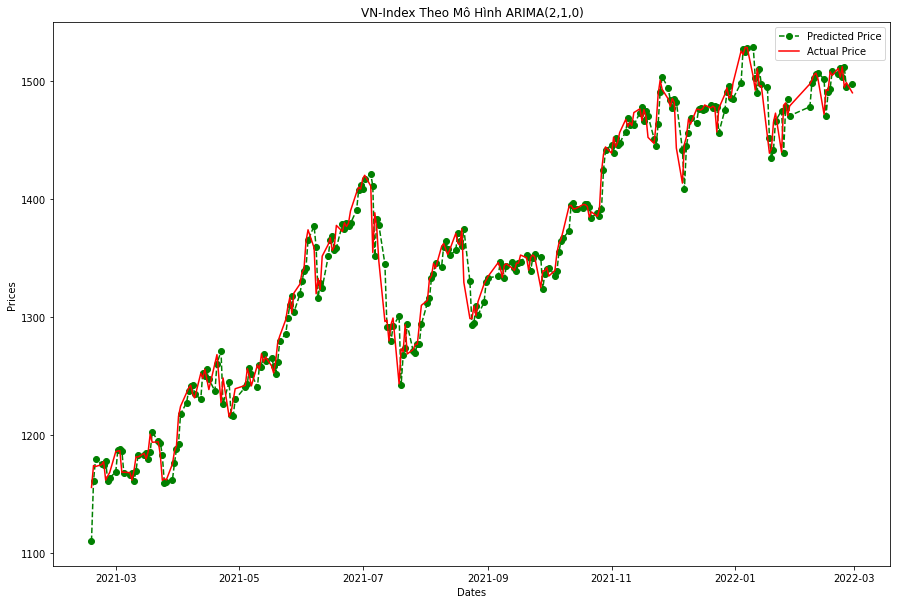

In [36]:
plt.figure(figsize=(15,10))

plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Price'], color='red', label='Actual Price')

plt.title('VN-Index Theo Mô Hình ARIMA(2,1,0)')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.legend()

**Các Thông số MAE, RMSE, MSE của mô hình ARIMA(2,1,0) tốt hơn nên mô hình ARIMA(2,1,0) được chon**